<a href="https://colab.research.google.com/github/sandratreneska/Self-supervised-visual-feature-learning/blob/main/VOC_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install scikit-multilearn

     |████████████████████████████████| 89 kB 6.5 MB/s 


In [ ]:
import os
from tensorflow import keras
import tensorflow as tf
import cv2
import math
import pickle
from keras import utils
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout, Flatten, Dense
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from sklearn import preprocessing
from skimage.color import rgb2lab
from keras import backend as K
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import multilabel_confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from skmultilearn.model_selection import iterative_train_test_split
from skmultilearn.model_selection import IterativeStratification

In [ ]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Check if GPU is connected
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('GPU device not found')
print('Found GPU at: {}'.format(device_name))

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Found GPU at: /device:GPU:0
Num GPUs Available:  1


In [ ]:
# Directories and parameters
DIR = '/content/drive/My Drive/Self-supervised-VOC/'
directory_annotations = DIR + 'VOC2012/Annotations/'
directory_images = DIR + 'VOC2012/JPEGImages/'
saved_weights_path = DIR + 'SavedWeights/'
saved_models_path = DIR + 'SavedModels/'
model_name = 'scratch-class-coco-balanced' # change
GEN_PATH = DIR + 'PretrainedGenerator/pix2pixCOCO.h5' # change
IMG_WIDTH = 256
IMG_HEIGHT = 256
BATCH_SIZE = 32
LEARNING_RATE_1 = 3e-4
LEARNING_RATE_2 = 5e-5 # 3e-4 change
EPOCHS = 10 # 20  change
NUM_CLASSES = 20

In [ ]:
# Save image names
filenames = []
i = 0
for xml_file in os.listdir(directory_annotations):
    if os.path.isfile(directory_annotations + xml_file):
      imgname = xml_file.strip('.xml')
      #print(imgname)
      filenames.append(imgname)
      print(i)
      i = i + 1

print(filenames)

In [ ]:
# Encode the labels
labelnames = preprocessing.LabelEncoder()
labelnames.fit(["aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car",
                "cat", "chair", "cow", "diningtable", "dog", "horse", "motorbike",
                "person", "pottedplant", "sheep", "sofa", "train", "tvmonitor"])

LabelEncoder()

In [ ]:
# Return the image and its label, from a given filename
def generate_from_xml(filename):
  label = np.zeros((NUM_CLASSES), dtype = 'float32')
  tree = ET.parse(os.path.join(directory_annotations, filename + ".xml"))
  #raw_image = cv2.imread(os.path.join(directory_images, filename + ".jpg")) # read image
  raw_image = tf.keras.preprocessing.image.load_img(os.path.join(directory_images, filename + ".jpg"), color_mode='rgb', target_size= (IMG_HEIGHT,IMG_WIDTH))
  res_img = np.array(raw_image, dtype=np.float32)
  #res_img = cv2.resize(raw_image, (IMG_WIDTH,IMG_HEIGHT)) # resize image

  # Preprocess
  res_img = res_img / 255. # to srgb [0, 1]
  lab_img = rgb2lab(res_img)  # convert from srgb to lab
  gray_lab = lab_img[:, :, 0] / 50. - 1.  # grayscale layer, between [-1, 1]
  color_lab = lab_img[:, :, 1:] / 128.  # green-red and blue-yellow layers, normalize between [-1, 1]
  img = np.zeros((IMG_WIDTH, IMG_HEIGHT, 3))  # zeroes matrix
  img[:, :, 0] = gray_lab  # grayscale, change with only grayscale
  img[:, :, 1:] = color_lab  # original two layers

  gray_lab = gray_lab.reshape(gray_lab.shape + (1,)) # convert from (256,256) to (256,256,1)

  # Find the labels ex. [1 0 0 1 ...] multiclass
  for elems in tree.iter():
    if elems.tag == "object":
      name = elems.find("name").text
      labelnr = labelnames.transform([name])[0]
      label[labelnr] = 1
      
  return gray_lab, label

In [ ]:
def iterative_train_test_split(X, y, train_size):
    """Custom iterative train test split which
    'maintains balanced representation with respect
    to order-th label combinations.'
    """
    stratifier = IterativeStratification(
        n_splits=2, order=1, sample_distribution_per_fold=[1.0-train_size, train_size, ])
    train_indices, test_indices = next(stratifier.split(X, y))
    X_train, y_train = X[train_indices], y[train_indices]
    X_test, y_test = X[test_indices], y[test_indices]
    return X_train, X_test, y_train, y_test

In [ ]:
# Indexes for splitting the dataset into train, val, test

'''
filecount = len(filenames)
indexes = []
labels = []
for index in range(filecount):
     indexes.append(index)

for filename in filenames:
    _, label = generate_from_xml(filename)
    labels.append(label)
'''

In [ ]:
'''
indexes = np.array(indexes)
labels = np.array(labels)
training_indexes, X_valtest, y_train, y_valtest = iterative_train_test_split(indexes, labels, train_size = 0.7)
validation_indexes, testing_indexes, y_val, y_test = iterative_train_test_split(X_valtest, y_valtest, train_size = 0.66)
'''

In [ ]:
'''
print(len(training_indexes))
print(len(y_train))
print(len(testing_indexes))
print(len(y_test))
print(training_indexes[3100:3150])
print(y_train[3000:3010])
'''

In [ ]:
'''
num_train_samples = len(training_indexes)
num_val_samples = len(validation_indexes)
num_test_samples = len(testing_indexes)

print("Num. training images", num_train_samples)
print("Num. val images", num_val_samples)
print("Num. test images", num_test_samples)
'''

In [ ]:
# Save train, val, test index splits
'''
np.savetxt(DIR + 'VOC2012/Classification_indexes/class_train_indexes.txt', training_indexes, fmt='%d')
np.savetxt(DIR + 'VOC2012/Classification_indexes/class_val_indexes.txt', validation_indexes, fmt='%d')
np.savetxt(DIR + 'VOC2012/Classification_indexes/class_test_indexes.txt', testing_indexes, fmt='%d')
'''

In [ ]:
# Load train, val, test index splits
training_indexes = np.loadtxt(DIR + 'VOC2012/Classification_indexes/class_train_indexes.txt', dtype=int)
validation_indexes = np.loadtxt(DIR + 'VOC2012/Classification_indexes/class_val_indexes.txt', dtype=int)
testing_indexes = np.loadtxt(DIR + 'VOC2012/Classification_indexes/class_test_indexes.txt', dtype=int)

In [ ]:
# Example
img, label = generate_from_xml('2007_000063')
#print(img)

In [ ]:
class DataGenerator(utils.all_utils.Sequence):
  

  def __init__(self, list_IDs, datafiles, batch_size = BATCH_SIZE, n_classes = NUM_CLASSES, shuffle = True):
    self.batch_size = batch_size
    self.datafiles = datafiles
    self.list_IDs = list_IDs
    self.n_classes = n_classes
    self.shuffle = shuffle
    self.on_epoch_end()

  # After each epoch, shuffle the images if true
  def on_epoch_end(self):
    self.indexes = np.arange(len(self.list_IDs))
    if self.shuffle == True:
      np.random.shuffle(self.indexes)

  # Generate images and labels for a batch
  def __data_generation(self, list_IDs_temp):

    # Initialization
    X = np.empty((self.batch_size, IMG_WIDTH, IMG_HEIGHT, 1))
    y = np.empty((self.batch_size, NUM_CLASSES))

    # For every image in the batch
    for datactr in range (self.batch_size):
      newimg, newlabel = generate_from_xml(self.datafiles[list_IDs_temp[datactr]])

      y[datactr] = newlabel
    
      X[datactr] = newimg

    return X, y

  # Number of batches per epoch
  def __len__(self):
    return int(np.floor(len(self.list_IDs) / self.batch_size))


  def __getitem__(self, index):
  # Generate indexes of the batch
    newindexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

  # Find list of IDs
    list_IDs_temp = [self.list_IDs[k] for k in newindexes]

  # Generate data
    X, y = self.__data_generation(list_IDs_temp)

    return X, y

In [ ]:
training_generator = DataGenerator(training_indexes, filenames)
val_generator = DataGenerator(validation_indexes, filenames)

In [ ]:
# define an encoder block
def define_encoder_block(layer_in, n_filters, batchnorm=True):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # add downsampling layer
    g = Conv2D(n_filters, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(layer_in)
    # conditionally add batch normalization
    if batchnorm:
        g = BatchNormalization()(g, training=True)
    # leaky relu activation
    g = LeakyReLU(alpha=0.2)(g)
    return g

In [ ]:
# define the classification model
def define_model(image_shape=(IMG_WIDTH, IMG_HEIGHT, 1)): # change channels to one
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # image input
    in_image = Input(shape=image_shape)
    # encoder model: C64-C128-C256-C512-C512-C512-C512-C512
    e1 = define_encoder_block(in_image, 64, batchnorm=False)
    e2 = define_encoder_block(e1, 128)
    e3 = define_encoder_block(e2, 256)
    e4 = define_encoder_block(e3, 512)
    e5 = define_encoder_block(e4, 512)
    e6 = define_encoder_block(e5, 512)
    e7 = define_encoder_block(e6, 512)
    # bottleneck, no batch norm and relu
    b = Conv2D(512, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(e7)
    b = Activation('relu')(b)
    x = Flatten()(b)  # Flatten dimensions for use in FC layers
    x = Dense(4096, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(4096, activation='relu')(x)
    x = Dropout(0.5)(x)

    out_image = Dense(NUM_CLASSES, activation='sigmoid')(x)
    classification_model = keras.Model(inputs=in_image, outputs=out_image)

    return classification_model

In [ ]:
def define_model_pretrained():

  # load pre-trained generator
  g_model = keras.models.load_model(GEN_PATH)
  # change freezed or not
  #g_model.trainable = False

  # get the encoder
  bottleneck_layer = 'activation'
  encoder = keras.Model(inputs=g_model.input, outputs=g_model.get_layer(bottleneck_layer).output)
  print(encoder.summary())

  # adding a classifier like VGG and Alexnet
  x = encoder.output
  x = Flatten()(x)  # Flatten dimensions for use in FC layers
  x = Dense(4096, activation='relu')(x)
  x = Dropout(0.5)(x)
  x = Dense(4096, activation='relu')(x)
  x = Dropout(0.5)(x)

  output = Dense(20, activation='sigmoid')(x)  # make num nodes with variable
  classification_model = keras.Model(inputs=encoder.input, outputs=output)

  return classification_model

In [ ]:
model = define_model()
#model = define_model_pretrained() # change
model.load_weights(saved_weights_path+'saved-weights-scratch-class-coco-balanced-04-0.17.hdf5')  #change

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE_1), loss='binary_crossentropy', metrics=['accuracy'])  # change lr
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 64)      1088      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 128)       131200    
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 128)       512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 256)       524544

In [ ]:
#earlyStopping = EarlyStopping(monitor='val_loss', verbose=0, mode='min', patience = 4) # patience - Number of epochs with no improvement after which training will be stopped
weights_save = ModelCheckpoint(saved_weights_path+'saved-weights-' + model_name + '-{epoch:02d}-{val_loss:.2f}.hdf5', verbose=1, save_weights_only=True, save_freq='epoch')

history = model.fit(training_generator, 
validation_data=val_generator,
use_multiprocessing=True,
workers=6,
epochs=EPOCHS,
callbacks=[weights_save])

In [ ]:
df = pd.DataFrame(history.history)
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
#load in the test set
labels_test = []
images_test = []
for testing_index in testing_indexes:
  image_test, label_test = generate_from_xml(filenames[testing_index])
  labels_test.append(label_test)
  images_test.append(image_test)
  print(testing_index)

images_test = np.array(images_test)
labels_test = np.array(labels_test)

loss, acc = model.evaluate(x=images_test,  y=labels_test, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100*acc))
print('Restored model, loss', loss)

In [ ]:
y_pred = model.predict(images_test)

In [ ]:
# Save history
with open(DIR + 'TrainHistory/class_coco_balanced_history', 'wb') as file_pi: # change name
    pickle.dump(history.history, file_pi)

In [ ]:
# Save  model
model.save(saved_models_path + 'saved-model-' + model_name) 

INFO:tensorflow:Assets written to: /content/drive/My Drive/Self-supervised-VOC/SavedModels/saved-model-scratch-class-coco-balanced/assets


In [ ]:
# Classification report
labels =["aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car",
                "cat", "chair", "cow", "diningtable", "dog", "horse", "motorbike",
                "person", "pottedplant", "sheep", "sofa", "train", "tvmonitor"]
y_pred = (y_pred > 0.5) # threshold 0.5
print(classification_report(labels_test, y_pred, target_names=labels))

class_accuracies = []
for class_ in np.unique(labels_test):
    class_acc = np.mean(y_pred[labels_test == class_] == class_)
    class_acuracies.append(class_acc)

print(class_acuracies)

In [ ]:
# Confusion matrix
cm = multilabel_confusion_matrix(labels_test, y_pred)
print(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

#disp.plot(cmap=plt.cm.Blues)
#plt.show()

## Loss Graphs

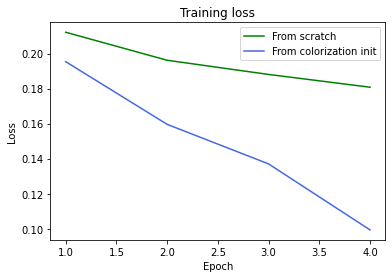

In [ ]:
epochs = [1,2,3,4]
train_loss_scratch = np.array([0.2122, 0.1962, 0.1881, 0.1808])
train_loss_pre = np.array([0.1954, 0.1596, 0.1370, 0.0993])

# Plotting both the curves simultaneously
plt.plot(epochs, train_loss_scratch, color='g', label='From scratch')
plt.plot(epochs, train_loss_pre, color='royalblue', label='From colorization init')
  
# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training loss")
  
# Adding legend, which helps us recognize the curve according to it's color
plt.legend()
  
# To load the display window
plt.show()